In [1]:
import torch 
import torchvision 
from torch import nn 
from torchvision import datasets,transforms  
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
train_data = datasets.MNIST(root='data',download=True,train=True,transform=transforms.ToTensor(),target_transform=None)
test_data = datasets.MNIST(root='data',download=True,train=False,transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32)
image,label = train_data[0]
print(f"Image shape:{image.shape}")
print(f"label: {label}") 
train_features_batch,train_labels_batch = next(iter(train_loader)) 
print(f"train_features_batch.shape:{train_features_batch.shape}") 
print(f"train_labels_batch.shape:{train_labels_batch.shape}")
class_names = train_data.classes
print(class_names)
len(train_data.data),len(train_data.targets),len(test_data.data),len(test_data.targets)


Image shape:torch.Size([1, 28, 28])
label: 5
train_features_batch.shape:torch.Size([32, 1, 28, 28])
train_labels_batch.shape:torch.Size([32])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


(60000, 60000, 10000, 10000)

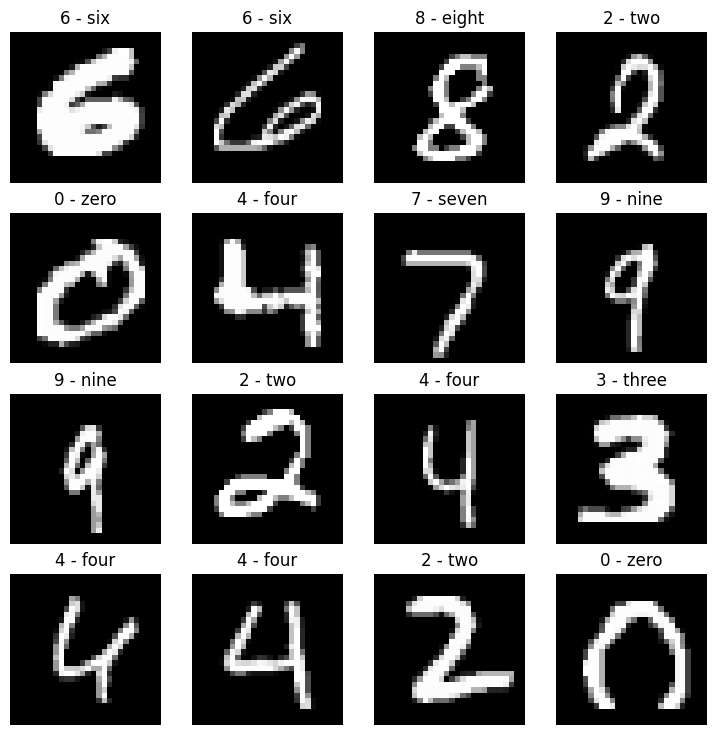

In [3]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols + 1):
    rand_idx = torch.randint(0,len(train_data),size=[1]).item()
    img,label = train_data[rand_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class CNN_MNIST(nn.Module):
    def __init__(self,input_shape, hidden_units,output_shape) -> None:
        super().__init__()
        
        self.blk1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.blk2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
        )
    
    def forward(self,x):
        x = self.blk1(x)
        #print(f"output of blk 1 {x.shape}")
        x = self.blk2(x)
        #print(f"output of blk 2 {x.shape}")    
        x = self.clf(x)
        #print(f"output of clf {x.shape}")
        return x     
    
torch.manual_seed(42)
model = CNN_MNIST(input_shape=1,hidden_units=10,output_shape=len(class_names)).to(device)
model

CNN_MNIST(
  (blk1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (blk2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [6]:
print(f"image.shape :{image.shape}")
random_image_tensor = torch.rand(size=(1,28,28))
print(f"random_image_tensor.shape: {random_image_tensor.shape}")
random_image_tensor = random_image_tensor.unsqueeze(dim=0)
print(f"random_image_tensor.shape: {random_image_tensor.shape}")

image.shape :torch.Size([1, 28, 28])
random_image_tensor.shape: torch.Size([1, 28, 28])
random_image_tensor.shape: torch.Size([1, 1, 28, 28])


In [7]:
model(random_image_tensor.to(device))

tensor([[ 0.0372, -0.0748,  0.0573, -0.0396, -0.0098,  0.0194, -0.0003, -0.0114,
          0.0206,  0.0003]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)  

In [9]:
def accuracy_fn(y,y_pred):
    acc = torch.eq(y,y_pred).sum().item()/len(y_pred)
    return acc

In [10]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss,train_acc = 0,0
    model.to(device)
    for batch,(X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss : {train_loss:4f} | Train accuracy : {train_acc:4f}")

def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    model.to(device)
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for X,y in data_loader:
             X,y = X.to(device),y.to(device)
             test_pred = model(X)
             test_loss += loss_fn(test_pred,y)
             test_acc += accuracy_fn(y,test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

In [11]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    print(f"Epoch:{epoch+1}------")
    train_step(model,train_loader,loss_fn,optimizer,accuracy_fn,device)
    test_step(model,test_loader,loss_fn,accuracy_fn,device)

Epoch:1------
Train loss : 0.215502 | Train accuracy : 0.932517
Test loss: 0.0735 | Test accuracy: 0.9777
Epoch:2------
Train loss : 0.069597 | Train accuracy : 0.978067
Test loss: 0.0456 | Test accuracy: 0.9858
Epoch:3------
Train loss : 0.053016 | Train accuracy : 0.983183
Test loss: 0.0449 | Test accuracy: 0.9860


In [12]:
def make_pred(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [13]:
import random 
test_samples,test_labels = [],[]
for sample,label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (5 - five)


In [14]:
pred_probs = make_pred(model,test_samples,device)
pred_probs[:2]
pred_classes = pred_probs.argmax(dim=1)
pred_classes,test_labels

(tensor([5, 0, 1, 7, 3, 1, 7, 9, 0]), [5, 0, 1, 7, 3, 1, 7, 9, 0])

In [15]:
from pathlib import Path
model_path = Path("Models")
model_path.mkdir(parents=True,exist_ok=True)
model_name = "CNN.pth"
model_save_path = model_path / model_name
print(f"Saving model to {model_path}")
torch.save(obj=model.state_dict(),f=model_save_path)

Saving model to Models


In [16]:
loaded_model = CNN_MNIST(input_shape=1,hidden_units=10,output_shape=len(class_names))
loaded_model.load_state_dict(torch.load(f=model_save_path))
loaded_model = loaded_model.to(device)
loaded_model

CNN_MNIST(
  (blk1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (blk2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [17]:
for param in loaded_model.state_dict().keys():
    print(f"{param}\t{loaded_model.state_dict()[param].size()}")
print()

blk1.0.weight	torch.Size([10, 1, 3, 3])
blk1.0.bias	torch.Size([10])
blk1.2.weight	torch.Size([10, 10, 3, 3])
blk1.2.bias	torch.Size([10])
blk2.0.weight	torch.Size([10, 10, 3, 3])
blk2.0.bias	torch.Size([10])
blk2.2.weight	torch.Size([10, 10, 3, 3])
blk2.2.bias	torch.Size([10])
clf.1.weight	torch.Size([10, 490])
clf.1.bias	torch.Size([10])



In [18]:
train_data = datasets.FashionMNIST(root='data',download=True,train=True,transform=transforms.ToTensor(),target_transform=None)
test_data = datasets.FashionMNIST(root='data',download=True,train=False,transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32)

In [19]:
loaded_model.eval()
acc = 0
total_samples = 0

for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    y_logit = loaded_model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    print(f"True label: {y}\nPredicted label: {y_pred}")
    
    acc += (y_pred == y).sum().item()
    total_samples += y.size(0)

accuracy = 100.0 * acc / total_samples
print(f"The overall accuracy: {accuracy}")


True label: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8], device='cuda:0')
Predicted label: tensor([2, 8, 8, 8, 9, 8, 3, 8, 2, 2, 0, 2, 2, 1, 8, 8, 2, 3, 0, 8, 3, 2, 2, 5,
        8, 0, 8, 8, 2, 9, 8, 2], device='cuda:0')
True label: tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5], device='cuda:0')
Predicted label: tensor([8, 8, 8, 8, 2, 2, 2, 1, 8, 8, 8, 2, 9, 1, 8, 8, 8, 8, 2, 9, 2, 6, 8, 2,
        0, 8, 0, 3, 2, 2, 2, 2], device='cuda:0')


True label: tensor([1, 1, 2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
        0, 6, 5, 3, 6, 7, 1, 8], device='cuda:0')
Predicted label: tensor([8, 8, 2, 9, 2, 8, 2, 3, 2, 8, 8, 8, 8, 8, 2, 8, 9, 8, 0, 2, 2, 8, 8, 9,
        8, 0, 2, 8, 8, 2, 8, 0], device='cuda:0')
True label: tensor([0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4], device='cuda:0')
Predicted label: tensor([8, 8, 8, 8, 3, 8, 2, 8, 2, 0, 2, 2, 1, 8, 0, 2, 2, 8, 5, 8, 0, 8, 2, 2,
        5, 8, 2, 1, 8, 8, 3, 0], device='cuda:0')
True label: tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6, 2, 2, 4, 4,
        1, 4, 5, 0, 4, 7, 9, 3], device='cuda:0')
Predicted label: tensor([8, 5, 8, 8, 2, 8, 0, 0, 9, 8, 8, 2, 8, 2, 8, 8, 8, 6, 8, 8, 8, 9, 8, 8,
        8, 9, 2, 9, 9, 2, 1, 2], device='cuda:0')
True label: tensor([7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6,
        7, 9, 9, 4, 4, 7, 1, 2], device='

In [20]:
y_preds = []
with torch.inference_mode():
    for X,y in test_loader:
        X,y = X.to(device),y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor

tensor([2, 8, 8,  ..., 8, 8, 2])

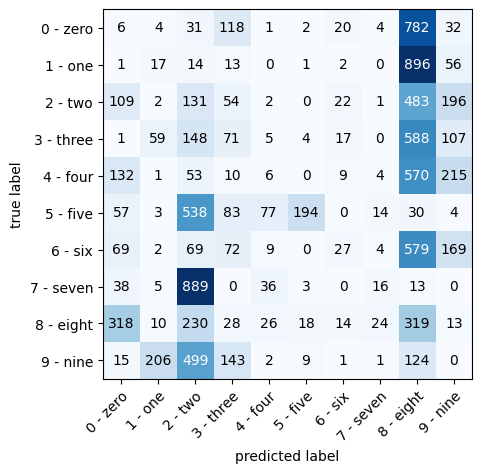

In [21]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(num_classes=len(class_names),task='multiclass')
confmat_tensor = confmat(preds=y_preds_tensor,target=test_data.targets)
fig,ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                               class_names=class_names)

In [1]:
import torch 
from torch import nn
import torchvision
from torchvision.models import alexnet
from torchvision.models import AlexNet_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [2]:
weights = AlexNet_Weights.DEFAULT
weights

AlexNet_Weights.IMAGENET1K_V1

In [4]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [6]:
model = alexnet(weights=weights).to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
for param in model.features.parameters():
    param.requires_grad = False

In [21]:
train_data = ImageFolder(root=r'C:\Users\rsurs\OneDrive\Documents\University_Study Material\3rd year\6th sem\DL_lab\RNN\CNN\cats_and_dogs_filtered\cats_and_dogs_filtered\train',transform=auto_transform)
test_data = ImageFolder(root=r'C:\Users\rsurs\OneDrive\Documents\University_Study Material\3rd year\6th sem\DL_lab\RNN\CNN\cats_and_dogs_filtered\cats_and_dogs_filtered\validation',transform=auto_transform)
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32)

In [16]:
class_names = train_data.classes
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features,output_shape,bias=True)
).to(device)

In [17]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [22]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_loader,loss_fn,optimizer,device)
    test_step(model,test_loader,loss_fn,device)

Epoch 0:------
Train Loss: 8.2155 | Train Accuracy: 0.7560
Test Loss: 0.1137 | Test Accuracy: 0.9590
Epoch 1:------
Train Loss: 0.1621 | Train Accuracy: 0.9385
Test Loss: 0.1879 | Test Accuracy: 0.9258
Epoch 2:------
Train Loss: 0.1054 | Train Accuracy: 0.9573
Test Loss: 0.0821 | Test Accuracy: 0.9697
Epoch 3:------
Train Loss: 0.0986 | Train Accuracy: 0.9638
Test Loss: 0.1526 | Test Accuracy: 0.9492
Epoch 4:------
Train Loss: 0.0717 | Train Accuracy: 0.9732
Test Loss: 0.1013 | Test Accuracy: 0.9658


In [23]:

import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import os

train_data = datasets.MNIST(root='./data', download=True, train=True, transform=ToTensor(), target_transform=None)
test_data = datasets.MNIST(root='./data', download=True, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"

class_names = train_data.classes

class CNNclf(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=3),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2))
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 20, bias=True),
            nn.ReLU(),
            nn.Linear(20, 10, bias=True))

    def forward(self, x):
        x = self.net(x)
        x = self.clf(x)
        return x

def accuracy_fn(y, y_pred):
    correct = torch.eq(y_pred, y).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

loss_fn = nn.CrossEntropyLoss()
model = CNNclf().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

def train_step(model, data_loader, device, optimizer, loss_fn, accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} Train accuracy: {train_acc:.5f}")
    return train_loss

def test_step(model, data_loader, device, loss_fn, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")
    return test_loss

checkpoints_dir = 'checkpoints'
os.makedirs(checkpoints_dir,exist_ok=True)
torch.manual_seed(42)
best_test_loss = float('inf')
torch.manual_seed(42)
for epoch in range(epochs):
    print(f"Epoch:{epoch}\n--------")
    train_loss = train_step(model, train_loader, device, optimizer, loss_fn, accuracy_fn)
    test_loss = test_step(model, test_loader, device, loss_fn, accuracy_fn)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        checkpoint = {
            'epoch':epoch+1,
            'model_state_dict':model.state_dict(),
            'optimizer.state_dict':optimizer.state_dict(),
            'test_loss':test_loss,
            'train_loss':train_loss
        }
        torch.save(checkpoint,os.path.join(checkpoints_dir,f'checkpoint_epoch_{epoch + 1}.pt'))
        print('Checkpt saved')

Epoch:0
--------
Train loss: 0.21159 Train accuracy: 93.41167
Test loss: 0.08226 | Test accuracy: 97.42412
Checkpt saved
Epoch:1
--------
Train loss: 0.06411 Train accuracy: 98.01500
Test loss: 0.05086 | Test accuracy: 98.52236
Checkpt saved
Epoch:2
--------
Train loss: 0.04378 Train accuracy: 98.65167
Test loss: 0.05430 | Test accuracy: 98.43251
Epoch:3
--------
Train loss: 0.03352 Train accuracy: 98.97667
Test loss: 0.04441 | Test accuracy: 98.71206
Checkpt saved
Epoch:4
--------
Train loss: 0.02630 Train accuracy: 99.16667
Test loss: 0.03688 | Test accuracy: 98.88179
Checkpt saved
